In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression


# Load your two datasets into pandas DataFrames
df_temperatures = pd.read_csv('../Resources/state_temperatures.csv')
df_flu = pd.read_csv('../Resources/flu_data.csv', skiprows=1)


# Ensure the columns we want to merge on have the same data type
df_temperatures['Year'] = df_temperatures['Year'].astype(int)
df_temperatures['Month'] = df_temperatures['Month'].astype(int)
df_temperatures['Week'] = df_temperatures['Week'].astype(int)
df_temperatures['State'] = df_temperatures['State'].astype(str)

df_flu['Year'] = df_flu['YEAR'].astype(int)
df_flu['Week'] = df_flu['WEEK'].astype(int)
df_flu['State'] = df_flu['REGION'].astype(str)

# Filter flu data to only include states present in the temperature data
df_flu = df_flu[df_flu['State'].isin(df_temperatures['State'].unique())]

# Merge the dataframes on State, Year, Month and Week
df_merged = pd.merge(df_temperatures, df_flu, on=['State', 'Year', 'Week'], how='inner')

# Drop duplicate columns
df_merged = df_merged.drop(columns=['YEAR', 'WEEK', 'REGION'])

# Save the merged dataset to a new CSV file
df_merged.to_csv('merged_data.csv', index=False)

# Convert 'ILITOTAL' to numeric, coercing non-numeric values to NaN
df_merged['ILITOTAL'] = pd.to_numeric(df_merged['ILITOTAL'], errors='coerce')

# Now handle the NaN values as described before
df_merged = df_merged.dropna(subset=['AverageTemperature', 'ILITOTAL'])

#Drop the rows with year 2020 from the merged data
df_merged = df_merged[df_merged['Year'] != 2020]

# Save the merged dataset to a new CSV file
df_merged.to_csv('merged_data.csv', index=False)

# Show the merged dataframe
df_merged.head()

,State,Year,Month,Week,AverageTemperature,REGION TYPE,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,Arizona,2016,1,1,39.246307,States,X,2.77037,X,X,X,X,X,X,644.0,58,23246
1,Arizona,2016,1,2,37.001854,States,X,2.78806,X,X,X,X,X,X,678.0,59,24318
2,Arizona,2016,1,3,45.848320,States,X,3.02494,X,X,X,X,X,X,666.0,58,22017
3,Arizona,2016,1,4,45.995705,States,X,3.40586,X,X,X,X,X,X,778.0,51,22843
4,Arizona,2016,2,5,37.523705,States,X,3.97859,X,X,X,X,X,X,892.0,51,22420


In [5]:
#Correlation Analysis
#This would allow you to measure the strength and direction of the relationship between the average temperature and the number of flu patients
# Replace 'X' with NaN
df_merged['ILITOTAL'] = df_merged['ILITOTAL'].replace('X', np.nan)

# Convert 'ILITOTAL' to numeric, coercing non-numeric values to NaN
df_merged['ILITOTAL'] = pd.to_numeric(df_merged['ILITOTAL'], errors='coerce')

# Drop rows with NaN in 'AverageTemperature' or 'ILITOTAL'
df_merged = df_merged.dropna(subset=['AverageTemperature', 'ILITOTAL'])

# Now calculate the correlation
correlation = df_merged['AverageTemperature'].corr(df_merged['ILITOTAL'])

print(correlation)

0.04768883979796067


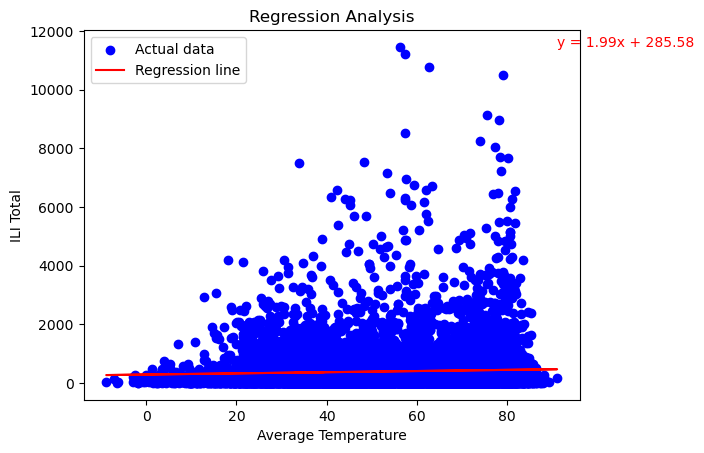

Coefficient (slope of the line):  [[1.99116074]]
Intercept (y-intercept of the line):  [285.57714624]


In [11]:
# Proceed with the model fitting
X = df_merged['AverageTemperature'].values.reshape(-1,1)
y = df_merged['ILITOTAL'].values.reshape(-1,1)

model = LinearRegression()
model.fit(X, y)

# Plotting
plt.scatter(X, y, color='blue', label='Actual data')  # Plot the data
plt.plot(X, model.predict(X), color='red', label='Regression line')  # Plot the regression line

plt.xlabel('Average Temperature')
plt.ylabel('ILI Total')
plt.title('Regression Analysis')
plt.legend()

# Display the equation of the line on the graph
plt.text(np.max(X), np.max(y), 'y = {:.2f}x + {:.2f}'.format(model.coef_[0][0], model.intercept_[0]), color='red')

# Save the plot as a PNG file
plt.savefig('regression_analysis.png', format='png')

plt.show()

# Print the coefficient and intercept
print('Coefficient (slope of the line): ', model.coef_)
print('Intercept (y-intercept of the line): ', model.intercept_)

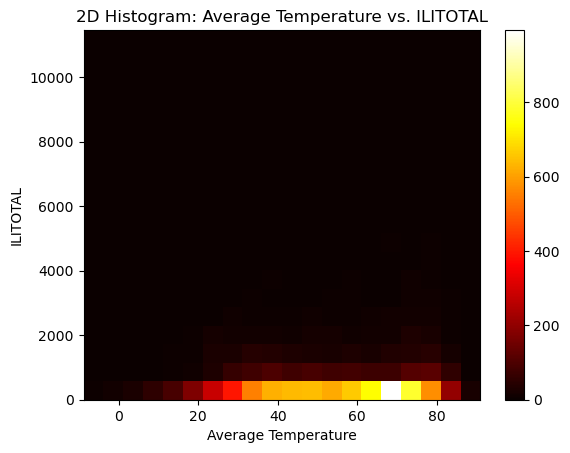

In [7]:
# Set the number of bins for each axis
bins_x = 20
bins_y = 20

# Create the 2D histogram
plt.hist2d(df_merged['AverageTemperature'], df_merged['ILITOTAL'], bins=(bins_x, bins_y), cmap='hot')

# Set the labels and title
plt.xlabel('Average Temperature')
plt.ylabel('ILITOTAL')
plt.title('2D Histogram: Average Temperature vs. ILITOTAL')

# Add a colorbar
plt.colorbar()

# Save the plot as a PNG file
plt.savefig('2D_Histogram_Average_Temperature_vs_ILITOTAL.png', format='png')

# Show the plot
plt.show()

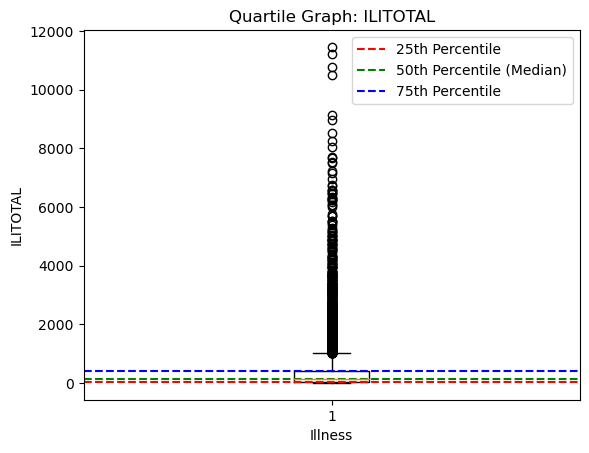

In [8]:
# Calculate quartiles
quartiles = df_merged['ILITOTAL'].quantile([0.25, 0.5, 0.75])

# Create a box plot
plt.boxplot(df_merged['ILITOTAL'])

# Add quartile lines
plt.axhline(y=quartiles[0.25], color='r', linestyle='--', label='25th Percentile')
plt.axhline(y=quartiles[0.5], color='g', linestyle='--', label='50th Percentile (Median)')
plt.axhline(y=quartiles[0.75], color='b', linestyle='--', label='75th Percentile')

# Set the x-axis label and y-axis label
plt.xlabel('Illness')
plt.ylabel('ILITOTAL')

# Set the title of the plot
plt.title('Quartile Graph: ILITOTAL')

# Add a legend
plt.legend()

# Save the plot as a PNG file
plt.savefig('Quartile_Graph.png', format='png')

# Show the plot
plt.show()

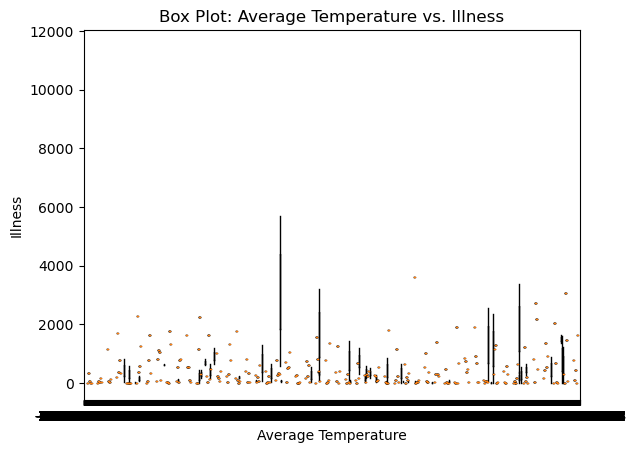

In [9]:
# Group the data by 'AverageTemperature'
grouped_data = df_merged.groupby('AverageTemperature')['ILITOTAL'].apply(list)

# Sort the groups based on 'AverageTemperature'
sorted_groups = grouped_data.sort_index()

# Create a list of lists to store the data for each group
data = sorted_groups.values.tolist()

# Create the figure and axis
fig, ax = plt.subplots()

# Create the box plots for each group
ax.boxplot(data)

# Set the x-axis labels
ax.set_xticklabels(sorted_groups.index)

# Set the x-axis label and y-axis label
ax.set_xlabel('Average Temperature')
ax.set_ylabel('Illness')

# Set the title of the plot
ax.set_title('Box Plot: Average Temperature vs. Illness')

# Save the plot as a PNG file
plt.savefig('Box_Plot.png', format='png')

# Show the plot
plt.show()

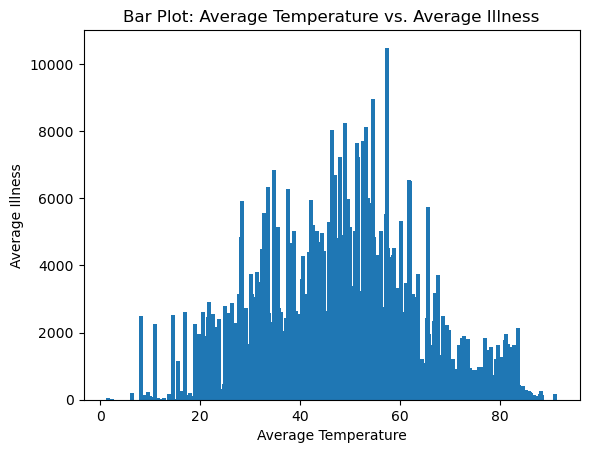

<Figure size 640x480 with 0 Axes>

In [7]:
avg_illness_by_temp = df_merged.groupby('AverageTemperature')['ILITOTAL'].mean()
plt.bar(avg_illness_by_temp.index, avg_illness_by_temp)
plt.xlabel('Average Temperature')
plt.ylabel('Average Illness')
plt.title('Bar Plot: Average Temperature vs. Average Illness')
plt.show()
# Save the plot as a PNG file
plt.savefig('Bar_Plot.png', format='png')